In [ ]:
import os
import requests
import numpy as np
import jax
import jax.numpy as jnp
from jax import random
import flax.linen as nn
import optax
from jax import value_and_grad
import pickle
import pandas as pd

from helper_funcs import generate, masked_fill, loss_fn, get_vector_batch, encode, decode
from tqdm import tqdm
import matplotlib.pyplot as plt
print(jax.devices())

[CudaDevice(id=0)]


W1212 15:24:27.571219   20748 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1212 15:24:27.575138   20663 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


## Parameter Selection

The Parameters used below are a scaled down version of GPT-2. GPT-2 has 4 different sizes, small, medium, large and xl. This GPT-2 could be considered an extra-small version. Note that these models may not be able to fit into RAM on your device. The exact specifications of the different sized models are shown below:

### GPT-2 Small
- n_embed: 768
- block_size: 1024
- num_heads: 12
- num_layers: 12
- vocab_size: 50257 (uses Tiktoken vocab)

### GPT-2 Medium
- n_embed: 1024
- block_size: 1024
- num_heads: 16
- num_layers: 24
- vocab_size: 50257 (uses Tiktoken vocab)

### GPT-2 Large
- n_embed: 1280
- block_size: 1024
- num_heads: 20
- num_layers: 36
- vocab_size: 50257 (uses Tiktoken vocab)

### GPT-2 XL
- n_embed: 1600
- block_size: 1024
- num_heads: 25
- num_layers: 48
- vocab_size: 50257 (uses Tiktoken vocab)

In [2]:
n_embed = 32 # Number of embedding dimensions
batch_size = 4 # How many independent sequences will we process in parallel?
block_size = 480 # What is the maximum context length for predictions?
num_heads = 4 # Number of heads in the multi-headed block
num_layers = 6 # Number of transformer decoder blocks
drop_rate = 0.1 # Dropout rate for regularization

rng_key = jax.random.PRNGKey(128)

## Data Preparation

In [3]:
with open('vocab.pickle', 'rb') as f:
    loaded_data = pickle.load(f)

vocab_size = len(loaded_data['vocab'])
print(vocab_size)

X = pd.read_parquet("X.parquet")
X

13359


,Power demand,temp,dwpt,rhum,wdir,wspd,pres,cluster,next_cluster,vector_id
0,1999.076667,8.0,6.9,93.0,0.0,0.0,1017.0,72,72,0
1,1952.006667,8.0,6.9,93.0,0.0,0.0,1017.0,72,72,0
2,1882.133333,8.0,6.9,93.0,0.0,0.0,1017.0,72,72,0
3,1822.866667,8.0,6.9,93.0,0.0,0.0,1017.0,72,72,0
4,1779.133333,8.0,6.9,93.0,0.0,0.0,1017.0,72,72,0
...,...,...,...,...,...,...,...,...,...,...
110663,3411.043333,22.0,3.1,29.0,320.0,13.0,1016.8,59,117,12808
110664,3506.576667,21.0,3.2,31.0,290.0,9.4,1017.0,117,117,0
110665,3504.670000,21.0,3.2,31.0,290.0,9.4,1017.0,117,117,0
110666,3478.290000,21.0,3.2,31.0,290.0,9.4,1017.0,117,117,0


In [4]:
# Test
df_slice = X.iloc[100:224]

v = encode(df_slice)
v

[18,
 0,
 0,
 0,
 19,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 20,
 0,
 0,
 21,
 22,
 23,
 0,
 0,
 24,
 0,
 25,
 0,
 26,
 0,
 0,
 0,
 27,
 0,
 0,
 0,
 28,
 0,
 0,
 0,
 29,
 0,
 0,
 0,
 30,
 0,
 0,
 31,
 32,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 33,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 34,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 35,
 0,
 0,
 0,
 0,
 0,
 36,
 0,
 0,
 0,
 37,
 0,
 0,
 0,
 38,
 0,
 0,
 0,
 39,
 0,
 0,
 0,
 40,
 0,
 41,
 0,
 42,
 0,
 0,
 43,
 0,
 0,
 0,
 0,
 0]

In [5]:
decode(v, X)

,Power demand,temp,dwpt,rhum,wdir,wspd,pres,cluster,next_cluster
0,1545.62,9.0,8.1,94.0,0.0,0.0,1017.0,72.0,550.0
1,1545.62,9.0,8.1,94.0,0.0,0.0,1017.0,72.0,550.0
2,1545.62,9.0,8.1,94.0,0.0,0.0,1017.0,72.0,550.0
3,1545.62,9.0,8.1,94.0,0.0,0.0,1017.0,72.0,550.0
4,1510.03,9.6,7.0,84.0,0.0,0.0,1018.1,550.0,1073.0
...,...,...,...,...,...,...,...,...,...
116,2861.26,12.0,11.1,94.0,70.0,9.4,1015.0,302.0,594.0
117,2861.26,12.0,11.1,94.0,70.0,9.4,1015.0,302.0,594.0
118,2861.26,12.0,11.1,94.0,70.0,9.4,1015.0,302.0,594.0
119,2861.26,12.0,11.1,94.0,70.0,9.4,1015.0,302.0,594.0


## Build the Attention Model

In [6]:
from attention_model import *

In [7]:
model = GPT2(vocab_size, n_embed, block_size, num_heads, num_layers, drop_rate)
dummy_x = jnp.zeros(shape=(batch_size, block_size), dtype=jnp.uint16)
variables = model.init(rng_key, dummy_x)

In [8]:
out = model.apply(variables, dummy_x)
print(out.shape)

(4, 480, 13359)


## Time Series Generation Pre-Training

In [9]:
index_seq = jnp.zeros(shape=(1,1), dtype=jnp.uint16)
max_new_tokens = 24
learning_rate=1e-4

#generated_indices = generate(variables, model.apply, index_seq, rng_key, vocab_size, 1, block_size, max_new_tokens)
#generated_indices = list(np.array(generated_indices[0]))
#decode(generated_indices, X)

## Train the Model

In [10]:
optimizer = optax.adamw(learning_rate=learning_rate)
opt_state = optimizer.init(variables)

In [11]:
epochs = 500
train_ids = X['vector_id'].to_numpy()
losses = []

pbar = tqdm(range(epochs))
for step in pbar:
    rng_key, subkey = jax.random.split(rng_key)
    xb, yb = get_vector_batch(train_ids, subkey, batch_size, block_size)

    loss, grads = value_and_grad(loss_fn, argnums=(0))(
        variables, 
        model.apply,
        xb, 
        yb
    )
    updates, opt_state = optimizer.update(grads, opt_state, variables)
    variables = optax.apply_updates(variables, updates) 
    losses.append(loss)
    
    pbar.set_description(f"Epoch: {step}, Loss: {loss :.4f}")

# Save model
model_file = {
    "epochs": epochs,
    "epoch": step,
    "model": model,
    "vocab_size": vocab_size,
    "block_size": block_size,
    "variables": variables,
    "losses": losses,
    "opt_state": opt_state,
    "learning_rate": learning_rate,
}

with open('model.pickle', 'wb') as f:
    pickle.dump(model_file, f)

Epoch: 499, Loss: 3.7426: 100%|██████████| 500/500 [10:34<00:00,  1.27s/it]


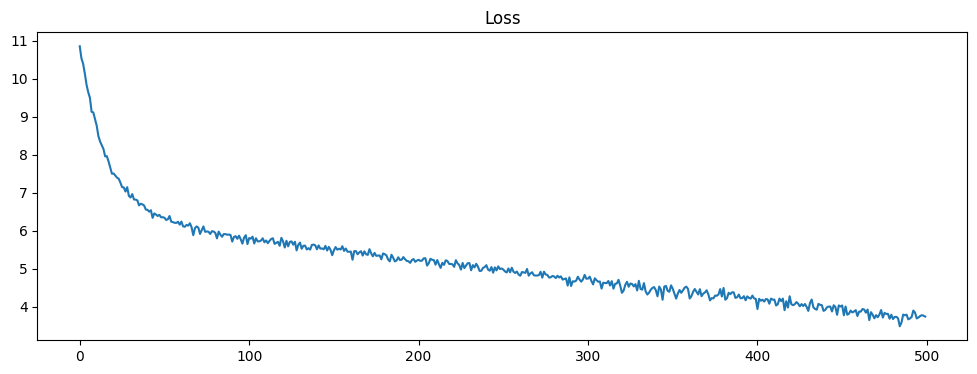

In [12]:
plt.figure(figsize=(12, 4))
plt.plot(losses)
plt.title('Loss')
plt.show()

## Time Series Generation Post-Training

In [20]:
rng_key, subkey = jax.random.split(rng_key)
max_new_tokens = 480
t = int(random.randint(rng_key, shape=(), minval=0, maxval=len(X)-(3*max_new_tokens)))

# Select a random batch (t)
X_test = X.iloc[t:t+max_new_tokens]
Y_test = X.iloc[t+max_new_tokens+1:t+max_new_tokens+max_new_tokens+1].reset_index()
x = [encode(X_test)]
index_seq = jnp.array(x)

print(index_seq.shape)
print(index_seq)

(1, 478)
[[ 177    0    0    0  216    0    0    0    0    0 5410    0    0    0
     0    0    0    0 5411    0    0    0 5389    0    0    0 5412    0
     0    0 5413    0    0    0 5414    0    0    0 5415    0    0    0
     0    0    0    0 5416    0    0    0 5318    0    0    0 5417    0
     0    0    0  578    0    0    0    0    0    0 5267    0    0    0
   215    0    0    0 5418    0    0    0 5419    0    0    0  405    0
     0    0 5420    0    0    0    0    0    0    0  333    0  595    0
  5421    0    0    0  180    0    0    0 5121    0    0    0 5422    0
     0    0    0    0    0 5423    0    0    0    0    0    0    0    0
   578    0    0    0 5424    0    0    0 5425    0    0    0 5131    0
     0    0    0    0    0    0    0    0    0    0 5426    0    0    0
  5421    0    0 5427 5428    0 5267    0    0    0    0  215    0    0
     0    0 5429    0    0    0  160    0    0    0 5430    0    0    0
  5429    0    0    0  160    0    0    0    0    0    

In [21]:
rng_key, subkey = jax.random.split(rng_key)
generated_indices = generate(variables, model.apply, index_seq, rng_key, vocab_size, 1, block_size, max_new_tokens)
generated_indices = list(np.array(generated_indices[0]))
Y = decode(generated_indices, X)

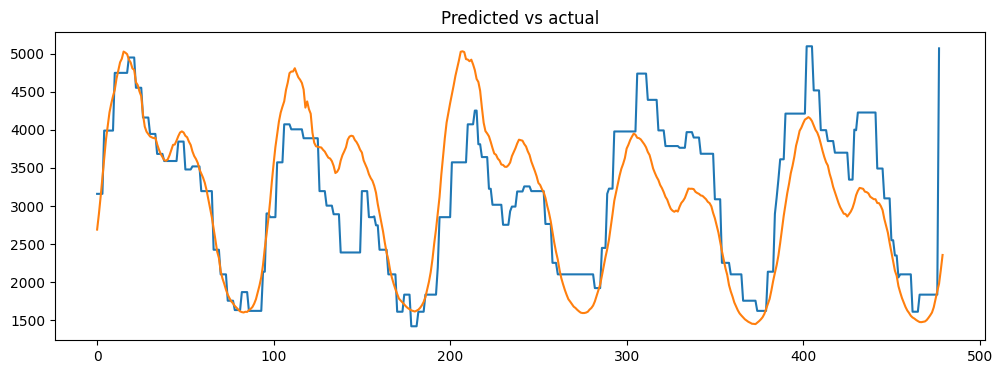

In [22]:
plt.figure(figsize=(12, 4))
plt.plot(Y.index, Y['Power demand'], label="Predicted")
plt.plot(Y_test.index, Y_test['Power demand'], label="Actual")
plt.title('Predicted vs actual')
plt.show()